In [1]:
import sys, pickle
sys.path.insert(0, "libs")

import os, pickle, csv # import packages for file I/O
import time # package to help keep track of calculation time

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import os

import scipy
import scipy.stats as sst
from scipy.special import comb
from scipy.integrate import simpson
from scipy.signal import argrelextrema
from random import choice

from libs.utils import *
from libs.finiteTheory import *
from visualizations import *
from libs.utils import *
from robustnessSimulations import *
from performanceMeasures import *
from infiniteTheory import *
from finiteTheory import *
from fnmatch import fnmatch

fvals = pickle.load(open('data/fvalues.p', 'rb'))
pvals = pickle.load(open('data/Pvalues.p', 'rb'))

In [2]:
def read_from_adj(filename):
    
    file = open(filename, "r")
    content = file.readlines()

    # convert into networkx graph
    node_list = []
    edge_list = [] #np.empty(len(content), dtype=object)
    
    if len(content) == 0:
        G = nx.Graph()
        return G
    
    edge_count = 0
    for i in range(len(content)):
        
        edge = content[i].strip()
        edge = edge.split(" ")
        
        if len(edge)==2:
            
            edge_list.append([int(edge[0]), int(edge[1])])
            node_list.append(int(edge[0]))
            node_list.append(int(edge[1]))

    node_list = list(set(node_list))
    
    if 0 in node_list:
        n = max(node_list) + 1
        offset = 0
    else:
        n = max(node_list)
        offset = min(node_list)
        
    adj = np.zeros((n, n))
        
    for k in range(len(edge_list)):
        adj[int(edge_list[k][0])-offset, int(edge_list[k][1])-offset] = 1
        adj[int(edge_list[k][1])-offset, int(edge_list[k][0])-offset] = 1

    G = nx.from_numpy_array(adj)
    file.close()
            
    return G

    
def random_removal(G0):
    
    # make a copy of input graph
    G = G0.copy()
    n = G.number_of_nodes()
    
    data_array = np.zeros(n, dtype=float)
    
    for i in range(n):
        # get LCC size
        data_array[i] = len(max(nx.connected_components(G), key=len)) / (n - i)
        # find a random node to remove
        if G.number_of_nodes() != 0:
            v = choice(list(G.nodes()))
            G.remove_node(v)
            
    return data_array

            
def targeted_removal(G0):
    
    # make a copy of input graph
    G = G0.copy()
    n = G.number_of_nodes()
    
    data_array = np.zeros(n, dtype=float)
    for i in range(n):
        # get LCC size
        data_array[i] = len(max(nx.connected_components(G), key=len)) / (n - i)
        # find highest-degree node and remove it
        if G.number_of_nodes() != 0:
            v = sorted(G.degree, key=lambda x: x[1], reverse=True)[0][0]
            G.remove_node(v)
            
    return data_array

def r_pow(x, n, d):
    """
    Compute x to the power of n/d (not reduced to lowest
    expression) with the correct function real domains.
    
    ARGS:
        x (int,float,array): base
        n (int)            : exponent numerator
        d (int)            : exponent denominator
        
    RETURNS:
        x to the power of n/d
    """
    
    # list to array
    if type(x) == list:
        x = np.array(x)
    # check inputs
    if type(n) != int or type(d) != int:
        raise Exception("Exponent numerator and denominator must be integers")
    # if denominator is zero
    if not d:
        raise Exception("Exponent denominator cannot be 0")
        
    # raise x to power of n
    X = x**n
    # even denominator
    if not d % 2:
        # domain is for X>=0 only
        if type(x) == np.ndarray:
            X[X<0] = np.nan
        elif X < 0:
            X = np.nan
        res = np.power(X, 1./d)
        return res
    # odd denominator
    else:
        # domain is all R
        res = np.power(np.abs(X), 1./d)
        res *= np.sign(X)
        return res
    

def check_space(string):
    '''Check if there is a space in a string to help identify edge list files.'''
    
    # counter
    count = 0

    # loop for search each index
    for i in range(0, len(string)):

        # Check each char
        # is blank or not
        if string[i] == " ":
            count += 1

    return count

In [3]:
# Get a list of networks

root = r'pholme_networks'
pattern = "*.adj"
pattern2 = "*.arc"
nwks_list = []

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            # print(os.path.join(path, name))
            nwks_list.append(os.path.join(path, name))
        elif fnmatch(name, pattern2):
            nwks_list.append(os.path.join(path, name))

df = pd.DataFrame(nwks_list)
df.to_csv("paths_to_networks.csv")

In [4]:
len(nwks_list)

2317

In [5]:
# select networks with less or equal to 100 nodes and more than 1 node

compute=False
min_counter=0
max_size=100

table = np.zeros((len(nwks_list),8), dtype=object)

counter = 0

for i, nwpath in enumerate(nwks_list):
    
    # extract file name from file path
    nwname = os.path.basename(nwpath)
    
    # add name of network to table
    table[counter,0] =  str(nwname)
    table[counter,1] =  str(nwpath)
    
    # read graph from ".adj" file
    #print('{} {}'.format(i, nwname), end='')
    G = read_from_adj(nwpath)

    # set p for G(n,p) graph
    n = G.number_of_nodes()
    m = G.number_of_edges()
    #print(' has (n,m) = ({}, {})'.format(n, m), end='')

    # check if network meets size limitation
    if n > max_size:
        print (' --- omit')
        continue
    elif n < 2:
        print(' --- omit')
        continue    
    else:
        print(' --- compute', end='')

    p = m / scipy.special.comb(n, 2)
    
    if compute:
        
        if counter >= min_counter:
            t0 = time.time()
            # add number of nodes and edges to info table
            table[counter,2] = n
            table[counter,3] = m

            # get data for random and targeted node removal 
            nw_r = np.nanmean([random_removal(G) for i in range(num_tries)], axis=0)
            nw_t = targeted_removal(G)
            
            # finite-theory results for random and targeted node removal
            theory_r = relSCurve(p, n, attack=False, reverse=True, lcc_method_relS="pmult")
            theory_t = relSCurve(p, n, attack=True, reverse=True, lcc_method_relS="pmult")
        
            # rel LCC arrays
            results = [nw_r, nw_t, theory_r, theory_t]
            for i, array in enumerate(results): 
                # store in info table
                table[counter,4+i] = array


            with open('data/fulldata-{}.txt'.format(counter), 'w') as file:
                # Write four lines to the file
                file.write("{} {} {}\n".format(nwname, n, m))
                file.write(' '.join(map(str, nw_r))+"\n")
                file.write(' '.join(map(str, nw_t))+"\n")
                file.write(' '.join(map(str, theory_r))+"\n")
                file.write(' '.join(map(str, theory_t))+"\n")

            #print(' in {} s'.format(time.time()-t0))
    
    counter+=1
    

if compute: 

    if min_counter==0:
        # remove empty rows from table
        table2 = table[:counter]

        # convert to data frame and name its columns
        df = pd.DataFrame(table2)
        df.columns = ["network", "nodes", "edges", "real rand rLCC", "real attack rLCC",
                        "fin theory rand rLCC", "fin theory attack rLCC"]
        
else:
    table = table[:counter]
    filename = 'networks2-100.p'
    pickle.dump(table[:,:3], open(filename, 'wb'))
    print('Identified {} networks with sizes 2 to 100 and saved their paths to {}.'.format(counter, filename))

0 10_19.adj has (n,m) = (10, 20) --- compute1 american_revolution.adj has (n,m) = (136, 3420) --- omit
2 birdtrade_a.adj has (n,m) = (42, 68) --- compute3 birdtrade_b.adj has (n,m) = (39, 53) --- compute4 birdtrade_c.adj has (n,m) = (34, 46) --- compute5 celegans_neural.adj has (n,m) = (280, 1973) --- omit
6 ce_nn.arc has (n,m) = (280, 1973) --- omit
7 chile_powergrid.adj has (n,m) = (466, 543) --- omit
8 dolphin.adj has (n,m) = (62, 159) --- compute9 dolphin.arc has (n,m) = (62, 159) --- compute10 drugspider_caffeine.adj has (n,m) = (119, 190) --- omit
11 drugspider_chloralhydrate.adj has (n,m) = (52, 64) --- compute12 earth.adj has (n,m) = (249, 1197) --- omit
13 earth.arc has (n,m) = (249, 1197) --- omit
14 earth_moon_mars.adj has (n,m) = (16, 57) --- compute15 east_europe_rr.adj has (n,m) = (45, 91) --- compute16 farmer.adj has (n,m) = (80, 77) --- compute17 flights.adj has (n,m) = (456, 2799) --- omit
18 flights.arc has (n,m) = (456, 2799) --- omit
19 football.adj has (n,m) = (115

In [6]:
# compute randomness index for networks with n in [2,100]

def bayesian(theory = False, removal = "random", adj_list = ["taro.txt"], oneplot = False, path=''):

    products, nums_nodes, probs = [], [], []

    for file_name in adj_list:
        #file_name = open(os.path.join(file_path,file_name), "r")
        #print(str(file_name))
        file = open(path+file_name, "r")
        #content = file.readlines()
        content = (line.rstrip() for line in file)  # All lines including the blank ones
        content = list(line for line in content if line)

        if len(content) == 0:
            # empty file
            print("None detected")
            product = "None"
            n = "None"
            p = "None"
            file.close()

        else:

            if True:
                node_list = []
                edge_list = np.empty(len(content), dtype=object)
                for i in range(len(content)):
                    edge = content[i].strip()
                    edge = edge.split(" ")
                    edge_list[i] = np.zeros(2)
                    edge_list[i][0] = int(edge[0])
                    edge_list[i][1] = int(edge[1])
                    for j in range(2):
                        node_list.append(int(edge[j]))
                n = max(node_list) + 1
                adj = np.zeros((n, n))
                #print("check1")

                for k in range(len(edge_list)):
                    adj[int(edge_list[k][0]), int(edge_list[k][1])] = 1
                    adj[int(edge_list[k][1]), int(edge_list[k][0])] = 1
                G_0 = nx.from_numpy_array(adj)
                p = len(edge_list) / scipy.special.comb(n, 2)
                degrees = list(G_0.degree())
                product = 1
                for i_d in range(len(degrees)):
                    d = degrees[i_d][1]
                    #print("d", d)
                    product *= scipy.special.comb(n - 1, d) * (p ** d) * (1 - p) ** (n - 1 - d)
                    #print("i_d", i_d)
                
                # plt.show()
                freq = nx.degree_histogram(G_0)
                #print(freq)
                for f in freq:
                    product /= math.factorial(f)
                product = product * math.factorial(n)
                #print("product", product)
                #print("n", n)

                product = r_pow(product, 1, n)


                products.append(product)
                nums_nodes.append(n)
                probs.append(p)
    
    return products,nums_nodes,probs

In [7]:
randomness_indices, nums_nodes, probs =randomness_indices, nums_nodes, probs = bayesian(theory = False, removal = "random", adj_list = table[:,1], oneplot = False, path='') bayesian(theory = False, removal = "random", adj_list = table[:,1], oneplot = False, path='')

In [8]:
# find top 20 networks based on randomness index
top20_i = np.array([i for i in range(len(table)) if randomness_indices[i]>=np.percentile(randomness_indices,80)]).T
top20 = np.array([[nums_nodes[i], randomness_indices[i]] for i in range(len(table)) if randomness_indices[i]>=np.percentile(randomness_indices,80)]).T

bottom20_i = np.array([i for i in range(len(table)) if randomness_indices[i]<np.percentile(randomness_indices,20)]).T
bottom20 = np.array([[nums_nodes[i], randomness_indices[i]] for i in range(len(table)) if randomness_indices[i]<np.percentile(randomness_indices,20)]).T



In [9]:
print(len(top20_i), len(top20[0]), len(bottom20_i), len(bottom20[0]))
print(top20_i)

In [48]:
# graph sizes of the top 20 graphs
nodes = np.array([nums_nodes[i] for i in top20_i])

array([0.09191919, 0.09259259, 0.06666667, 0.04494976, 0.03844414,
       0.06292517, 0.06612245, 0.06285714, 0.09098639, 0.03299799,
       0.04504505, 0.06701222, 0.83333333, 0.07820513, 0.12666667,
       1.        , 1.        , 1.        , 0.10114943, 0.08253968,
       1.        , 1.        , 0.06906907, 0.07446809, 0.03929825,
       0.03296703, 0.02969697, 0.03296703, 0.03396029, 0.03321123,
       0.04225352, 0.0393028 , 0.04347826, 0.04107981, 0.05731523,
       0.05806938, 0.06207483, 0.06040816, 0.05732946, 0.06294326,
       0.0318005 , 0.02989899, 0.03029665, 0.03180291, 0.03272814,
       0.03225806, 0.03180291, 0.03202431, 0.035263  , 0.03734177,
       0.03862804, 0.03861928, 0.03862804, 0.0393028 , 0.05454545,
       0.05325815, 0.05521886, 0.05806938, 0.0538961 , 0.05732946,
       0.05454545, 0.05590496, 0.05521886, 0.03050917, 0.03026316,
       0.02949495, 0.03421545, 0.03765823, 0.03613369, 0.03448276,
       0.03474692, 0.04072566, 0.03734568, 0.03643481, 0.03797

In [ ]:
ok_indices = []
for j in range(len(nodes)):
    if nodes[j] <= 30:
        ok_indices.append(j)

In [ ]:
y_t_indices = np.zeros(len(ok_indices))
counter = 0
for j2 in ok_indices:
    y_t_indices[counter] = top20_i[j2]
    counter +=1

In [ ]:
x_nodes = list(filter(lambda x : x <= 30, nodes))

In [ ]:
data = pd.read_csv("fullData.csv")
print(data)

In [ ]:
def nodecount_edge(file_name = ""):
    file = open(file_name, "r")
    #content = file.readlines()
    content = (line.rstrip() for line in file)  # All lines including the blank ones
    content = list(line for line in content if line)
    #print(content)
    node_list = []
    edge_list = np.empty(len(content), dtype=object)
    for i in range(len(content)):
        edge = content[i].strip()
        edge = edge.split(" ")
        edge_list[i] = np.zeros(2)
        #print("i", i)
        #print("edge[0]",edge[0])
        edge_list[i][0] = int(edge[0])
        edge_list[i][1] = int(edge[1])
        for j in range(2):
            node_list.append(int(edge[j]))
    if 0 in node_list:
        n = max(node_list) + 1
    else:
        n = max(node_list)
    return n


def nodecount_bi(file_name = ""):
    file = open(file_name, "r")
    content = file.readlines()
    n = len(content)
    if len(content[0]) > n:
        n = len(content[0])
    return n

def check_space(string):
    # counter
    count = 0

    # loop for search each index
    for i in range(0, len(string)):

        # Check each char
        # is blank or not
        if string[i] == " ":
            count += 1

    return count

def mega_file_reader2(removal = "random", adj_list = ["taro.txt"]):
    #, file_path = "C:\\Users\\jj\Downloads\\GitHub\small-perc\\pholme_networks" )
    if removal == "random":
        remove_bool = False
    elif removal == "attack":
        remove_bool = True
        
    for file_name in adj_list:

        file = open(file_name, "r")
        #file = open(os.path.join(file_path,file_name), "r")
        content=file.readlines()

        if len(content) == 0:
            file.close()
            averaged_data = "None"
            fin = "None"
        # identify type of file (biadjacency matrix, edge list)
            # edge list
        else:
            if nodecount_edge(file_name) > 100:
                file.close()
                averaged_data = "None"
                fin = "None"
            else:
                node_list = []
                edge_list = np.empty(len(content), dtype=object)
                for i in range(len(content)):
                    edge = content[i].strip()
                    edge = edge.split(" ")
                    edge_list[i] = np.zeros(2)
                    edge_list[i][0] = int(edge[0])
                    edge_list[i][1] = int(edge[1])
                    for j in range(2):
                        node_list.append(int(edge[j]))
                n = max(node_list) + 1
                adj = np.zeros((n, n))

                for k in range(len(edge_list)):
                    adj[int(edge_list[k][0]), int(edge_list[k][1])] = 1
                    adj[int(edge_list[k][1]), int(edge_list[k][0])] = 1
                
                G_0 = nx.from_numpy_array(adj)
                # G_0 = nx.algorithms.bipartite.matrix.from_biadjacency_matrix(adj, create_using=None)
                G = G_0.copy()
                p = len(edge_list) / scipy.special.comb(n, 2)
                averaged_data = np.zeros(n)
                #print("average")
                for j_2 in range(100):
                    G = G_0.copy()
                    # print(list(G.nodes()), "nodes")
                    data_array = np.zeros(n, dtype=float)
                    for i_2 in range(n):
                        #print(G.number_of_nodes(), "g size before")
                        data_array[i_2] = len(max(nx.connected_components(G), key=len)) / (n - i_2)
                        # find a node to remove
                        if removal == "random":
                            if G.number_of_nodes() != 0:
                                v = choice(list(G.nodes()))
                                G.remove_node(v)
                                # print(v)
                        elif removal == "attack":
                            if G.number_of_nodes() != 0:
                                v = sorted(G.degree, key=lambda x: x[1], reverse=True)[0][0]
                                G.remove_node(v)
                    averaged_data += data_array
                #print(x_array, "xarray")
                averaged_data /= 100
                #print(averaged_data, "y")

                fin = finiteTheory.relSCurve(p,n,attack=remove_bool, fdict=fvals,pdict=pvals,lcc_method_relS="pmult",
                                       executable_path = "small-perc/p-recursion.exe")
                return (averaged_data, fin)

In [ ]:
print(np.array(table[:,0]))
table2 = table[:,1].tolist()
table3 = table[:,0].tolist()


In [ ]:
for j3 in y_t_indices:
    values = mega_file_reader2(removal = "random", adj_list = [table2[int(j3)]])
    y_t[j3] = ((values[0]- values[1]) ** 2).mean()

In [ ]:
plt.plot(x_nodes, y_t)

In [ ]:
fullData = pd.read_csv("fullData.csv")

In [ ]:
#print(fullData.iloc[0][3])
#x = fullData.iloc[0][3][1:-1]
x = fullData.iloc[0][3]
n = int(fullData.iloc[0][1])
print(n)
print(x)
print(x[3])
new_array = np.zeros(n)
indices = np.zeros(n,dtype=object)
for i in range(n):
    indices[i] = []
counter = 0
ncounter = 0
print(len(x))
while ncounter < n:
    while counter < len(x):
        print(counter)
        if x[counter].isdigit():
            indices[ncounter].append(counter)
            counter += 1
            
        elif x[counter].isdigit() == False:
            counter += 1
            
        elif x[counter] == ".":
            if x[counter+1].isdigit():
                indices[ncounter].append(counter)
                counter += 1
            else:
                ncounter += 1
                start = x[indices[ncounter][0]]
                end = x[indices[ncounter][-1]]
                new_array[ncounter] = float(x[start:end])
                print(float(x[start:end]))
                counter += 1
print(new_array)
            
            
# for i in range(len(x)):
#     if isdigit(x[i]):
#         indexlist = []
#         indexlist.append(i)
#         if isdigit(x[i+1]):
#             new_array[i] = x[i]
# print(new_array)
# x = np.fromstring(x, float)
# print(x)
# print(x[0])

# x = np.array(fullData.iloc[0][3])
# print(type(x))
# print(x)
# print(x.size)
# for i in range(len(x)):
#     x[i] +=3
# print(x)


In [ ]:
t = len(top20_i)
b = len(bottom20_i)
l = len(fullData)
top20n100_array = np.zeros(t)
bot20n100_array = np.zeros(b)
mse_t100_array = np.zeros(t)
mse_b100_array = np.zeros(b)

for i in range(t):
    file_name = table3[t]
    for i_l in range(l):
        if fullData.iloc[i_l][0] == file_name:
            top20n100_array[i]= int(fullData.iloc[i_l][1])
            mse_t100_array[i] = ((np.array(fullData.iloc[i_l][3])-np.array(fullData.iloc[i_l][5]))**2).mean()
            
for j in range(b):
    file_name = table3[b]
    for i_l in range(l):
        if fullData.iloc[i_l][0] == file_name:
            bot20n100_array[j] = int(fullData.iloc[i_l][1])
            mse_t100_array[j] = ((np.array(fullData.iloc[i_l][3])-np.array(fullData.iloc[i_l][5]))**2).mean()

plt.plot(top20n100_array,mse_t100_array)
plt.savefig("top20,100")
plt.plot(bot20n100_array,mse_b100_array)
plt.savefig("bottom20,100")
    

In [ ]:
# select networks with less or equal to 100 nodes and more than 1 node

compute_100=True
min_counter_100=0
max_size_100=100
num_tries = 100

table_100 = np.zeros((len(nwks_list),8), dtype=object)

counter_100 = 0

for i, nwpath in enumerate(nwks_list):
    
    # extract file name from file path
    nwname = os.path.basename(nwpath)
    
    # add name of network to table
    table_100[counter,0] =  str(nwname)
    table_100[counter,1] =  str(nwpath)
    
    # read graph from ".adj" file
    #print('{} {}'.format(i, nwname), end='')
    G = read_from_adj(nwpath)

    # set p for G(n,p) graph
    n = G.number_of_nodes()
    m = G.number_of_edges()
    #print(' has (n,m) = ({}, {})'.format(n, m), end='')

    # check if network meets size limitation
    if n > max_size_100:
        print (' --- omit')
        continue
    elif n < 2:
        print(' --- omit')
        continue    
    else:
        print(' --- compute', end='')

    p = m / scipy.special.comb(n, 2)
    
    if compute_100:
        
        if counter_100 >= min_counter_100:
            t0 = time.time()
            # add number of nodes and edges to info table
            table_100[counter,2] = n
            table_100[counter,3] = m

            # get data for random and targeted node removal 
            nw_r = np.nanmean([random_removal(G) for i in range(num_tries)], axis=0)
            nw_t = targeted_removal(G)

            execute_pathname = os.path.join(os.getcwd(), 'libs/p-recursion.exe')

            
            # finite-theory results for random and targeted node removal
            theory_r = relSCurve(p, n, attack=False, reverse=True, lcc_method_relS="pmult",executable_path = execute_pathname)
            theory_t = relSCurve(p, n, attack=True, reverse=True, lcc_method_relS="pmult",executable_path = execute_pathname)
        
            # rel LCC arrays
            results = [nw_r, nw_t, theory_r, theory_t]
            for i, array in enumerate(results): 
                # store in info table
                table_100[counter_100,4+i] = array


            with open('data/fulldata-{}.txt'.format(counter), 'w') as file:
                # Write four lines to the file
                file.write("{} {} {}\n".format(nwname, n, m))
                file.write(' '.join(map(str, nw_r))+"\n")
                file.write(' '.join(map(str, nw_t))+"\n")
                file.write(' '.join(map(str, theory_r))+"\n")
                file.write(' '.join(map(str, theory_t))+"\n")

            #print(' in {} s'.format(time.time()-t0))
    
    counter_100+=1
    

if compute_100: 

    if min_counter_100==0:
        # remove empty rows from table
        table_1002 = table_100[:counter_100]

        # convert to data frame and name its columns
        df = pd.DataFrame(table_1002)
        df.columns = ["network", "networkpath", "nodes", "edges", "real rand rLCC", "real attack rLCC",
                        "fin theory rand rLCC", "fin theory attack rLCC"]
        df.to_pickle("new 100 limit data")

else:
    table_100 = table_100[:counter_100]
    filename = 'networks2-100.p'
    pickle.dump(table_100[:,:3], open(filename, 'wb'))
    print('Identified {} networks with sizes 2 to 100 and saved their paths to {}.'.format(counter, filename))

p 0.09191919191919191
p 0.09259259259259259
p 0.06666666666666667
p 0.0449497620306716
p 0.03844414292175486
p 0.06292517006802721
p 0.06612244897959184
p 0.06285714285714286
p 0.09098639455782313
p 0.03299798792756539
p 0.04504504504504504
p 0.0670122176971492
p 0.8333333333333334
p 0.0782051282051282
p 0.12666666666666668
p 1.0
p 1.0
p 1.0
p 0.10114942528735632
p 0.08253968253968254
p 1.0
p 1.0
p 0.06906906906906907
p 0.07446808510638298
p 0.03929824561403509
p 0.03296703296703297
p 0.029696969696969697
p 0.03296703296703297
p 0.03396029258098224
p 0.03321123321123321
p 0.04225352112676056
p 0.0393028024606972
p 0.043478260869565216
p 0.04107981220657277
p 0.05731523378582202
p 0.058069381598793365
p 0.06207482993197279
p 0.060408163265306125
p 0.057329462989840346
p 0.06294326241134751
p 0.03180050331731869
p 0.0298989898989899
p 0.030296654744371977
p 0.031802911534154536
p 0.0327281414237936
p 0.03225806451612903
p 0.031802911534154536
p 0.032024310425432446
p 0.03526300323244196


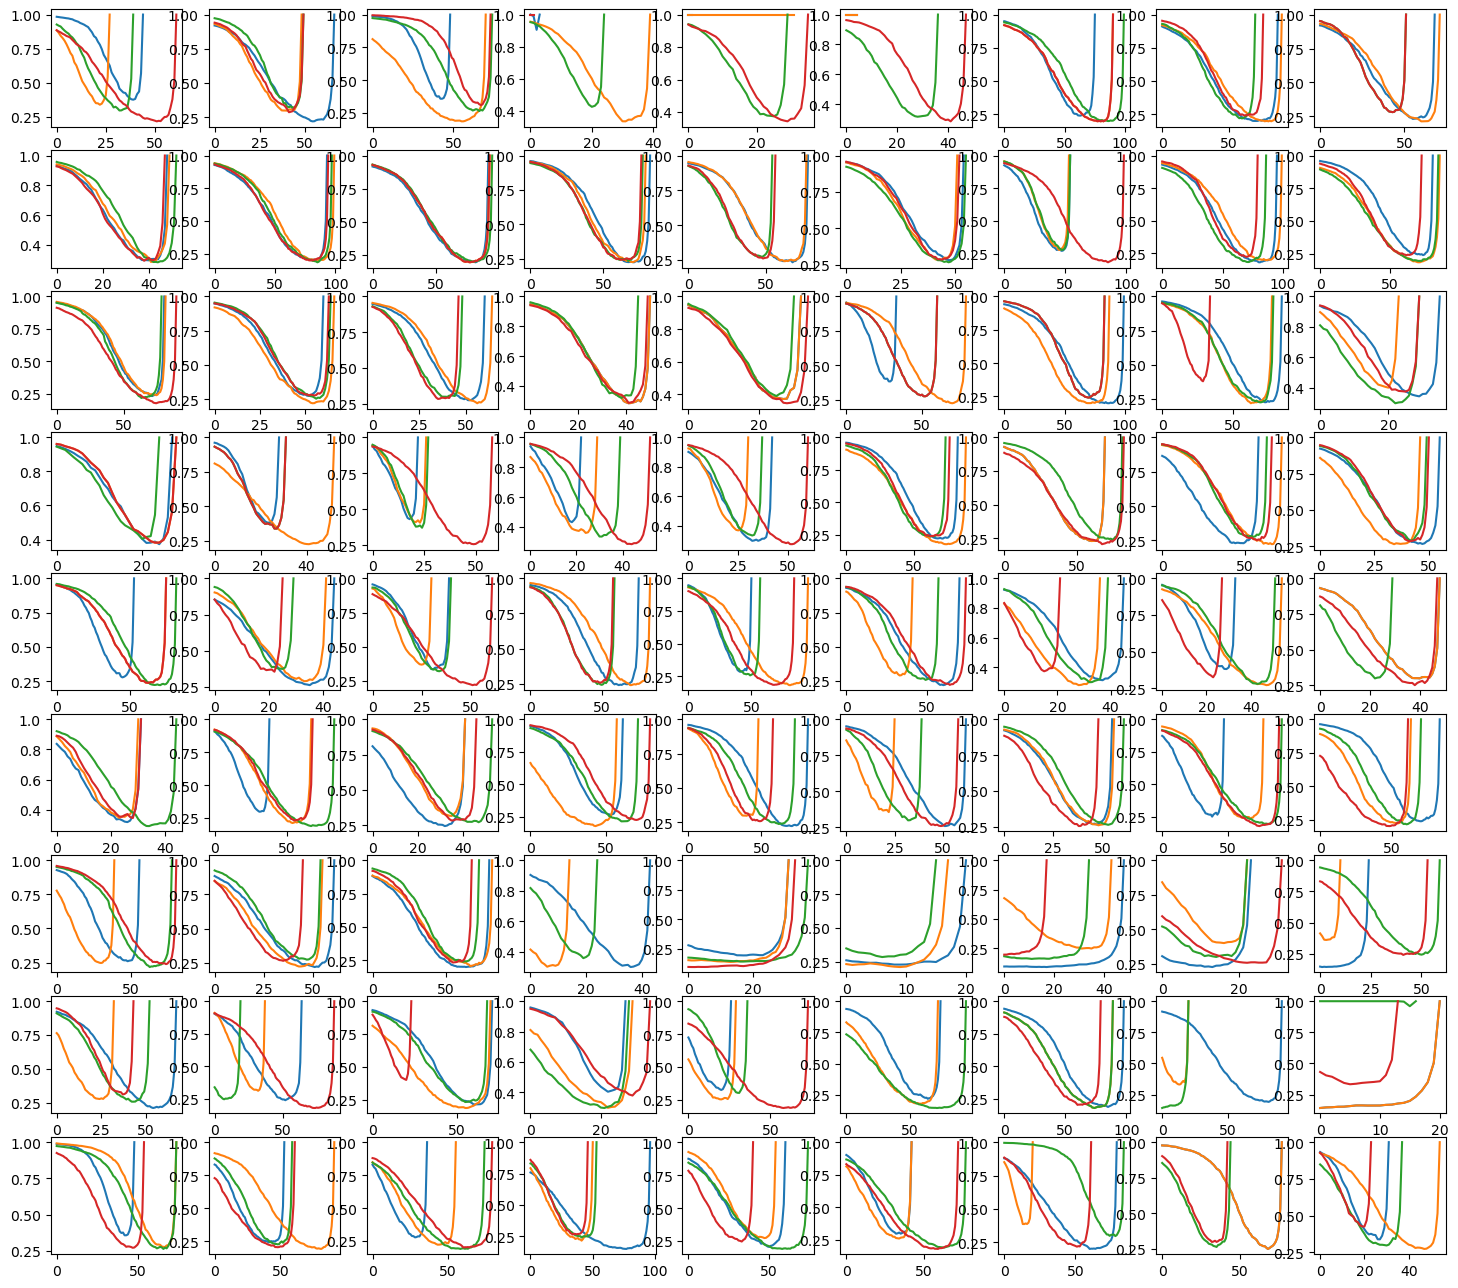

In [64]:
# compare mse with random mse
plt.figure(figsize=(18,18))
mse_data = np.zeros((len(top20.T),2))
for i, triple in enumerate(top20.T):
    #print(triple)
    n, p, r = triple
    search_index = top20_i[i]
    real_data = string2array(df['array1'][search_index])
    theory = string2array(df['array3'][search_index])
    real_data[real_data>1.05]=np.nan
    real_data[real_data<0]=np.nan
    theory[theory>1.05]=np.nan
    theory[theory<0]=np.nan    
    real_mse = np.mean((real_data-theory)**2)
    
    p_round = np.round(p,2)
    if p_round >= 0.01:
        print('p', p)
        n_int = int(n)
        if n <=100 and n>=2:
            theory = relSCurve_precalculated(n_int, p_round, targeted_removal=False, 
                                             simulated=False, finite=True)
            theory[theory>1.05]=np.nan
            theory[theory<0]=np.nan
            
            #print('theory.shape', theory.shape)
            sim = relSCurve_precalculated(n_int, p_round, targeted_removal=False, 
                                          simulated=True, finite=True)
            #print('sim.shape', sim.shape)
            sim[sim>1]=np.nan
            sim[sim<0]=np.nan
            sim = np.nanmean(sim, axis=1)
            ax = plt.subplot(10,9,1+i//4)
            ax.plot(sim)
            
            random_mse = np.mean((theory-sim)**2)
            mse_data[i] = [real_mse, random_mse]
        else:
            print('found network of size n={}'.format(n))   
            mse_data[i] = [np.nan, np.nan]
    else:
        print('found empty network with n={}, p={}'.format(n,p))       
        mse_data[i] = [np.nan, np.nan]

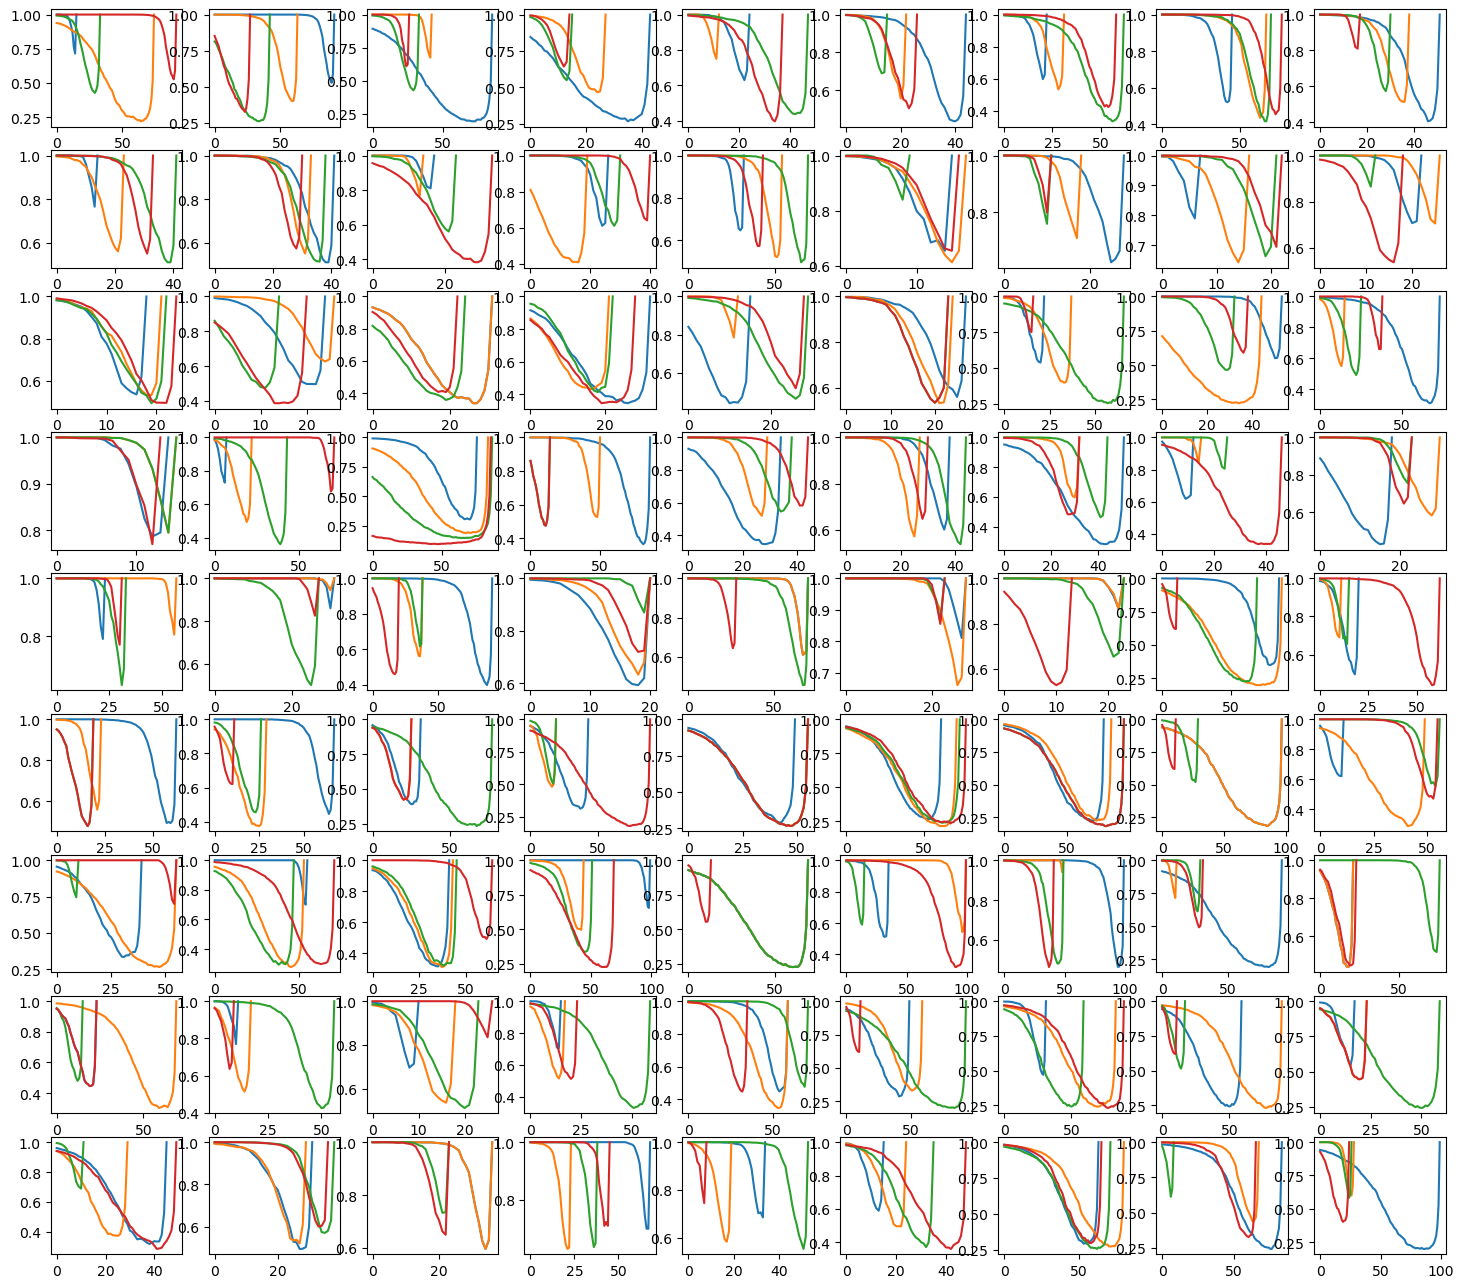

In [65]:
# compare mse with random mse
plt.figure(figsize=(18,18))
mse_data2 = np.zeros((len(bottom20.T),2))
for i, triple in enumerate(bottom20.T):
    #print(triple)
    n, p, r = triple
    search_index = bottom20_i[i]
    real_data = string2array(df['array1'][search_index])
    theory = string2array(df['array3'][search_index])
    real_data[real_data>1.05]=np.nan
    real_data[real_data<0]=np.nan
    theory[theory>1.05]=np.nan
    theory[theory<0]=np.nan    
    real_mse = np.mean((real_data-theory)**2)
    
    p_round = np.round(p,2)
    if p_round >= 0.01:
        n_int = int(n)
        if n <=100 and n>=2:
            theory = relSCurve_precalculated(n_int, p_round, targeted_removal=False, 
                                             simulated=False, finite=True)
            theory[theory>1.05]=np.nan
            theory[theory<0]=np.nan
            #ax = plt.subplot(10,9,1+i//4)
            #ax.plot(theory)
            
            sim = relSCurve_precalculated(n_int, p_round, targeted_removal=False, 
                                          simulated=True, finite=True)
            sim[sim>1.05]=np.nan
            sim[sim<0]=np.nan
            sim = np.nanmean(sim, axis=1)
            ax = plt.subplot(10,9,1+i//4)
            ax.plot(sim)
            #print('sim.shape', sim.shape)
            random_mse = np.nanmean((theory-sim)**2)
            mse_data2[i] = [real_mse, random_mse]
        else:
            print('found network of size n={}'.format(n))   
            mse_data2[i] = [np.nan, np.nan]
    else:
        print('found empty network with n={}, p={}'.format(n,p))    
        mse_data2[i] = [np.nan, np.nan]

In [69]:
# remove zeros
denom = np.copy(mse_data[:,1])
denom[mse_data[:,1]==0] = np.nan

denom2 = np.copy(mse_data2[:,1])
denom2[mse_data2[:,1]==0] = np.nan

print(np.nanmean(mse_data[:,0]-mse_data[:,1]))
print(np.nanmean(mse_data2[:,0]-mse_data2[:,1]))
print(np.nanmean(mse_data[:,0]/denom))
print(np.nanmean(mse_data2[:,0]/denom2))

0.03483618104586881
0.007841476232829088
340.65302862961767
126.42928591882318


In [68]:
np.sort(mse_data[:,1])

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.96613679e-06, 1.32813792e-05, 2.33588655e-05,
       2.69807826e-05, 2.72274291e-05, 2.72274291e-05, 2.92474610e-05,
       2.92900427e-05, 2.92900427e-05, 3.58428012e-05, 3.70474548e-05,
       3.78026418e-05, 3.78026418e-05, 3.82894391e-05, 3.83094090e-05,
       3.83094090e-05, 3.83094090e-05, 3.90927838e-05, 3.90927838e-05,
       3.90927838e-05, 3.92804953e-05, 3.99668602e-05, 3.99668602e-05,
       3.99719796e-05, 4.42599773e-05, 4.42599773e-05, 4.42599773e-05,
       4.42599773e-05, 4.71646094e-05, 4.98446921e-05, 4.98446921e-05,
       4.98446921e-05, 5.29001397e-05, 5.35269215e-05, 5.35269215e-05,
       5.35269215e-05, 5.48877396e-05, 5.74228557e-05, 5.74228557e-05,
       5.74228557e-05, 5.74228557e-05, 5.94737425e-05, 5.94737425e-05,
       6.17561203e-05, 6.17561203e-05, 6.30337073e-05, 6.30337073e-05,
       6.30337073e-05, 6.30337073e-05, 6.62543276e-05, 6.67879060e-05,
      

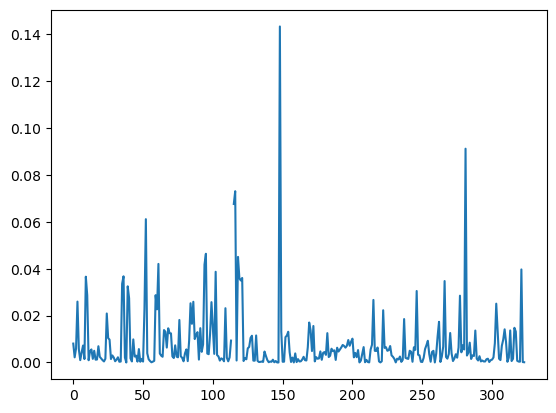

In [60]:
#plt.plot(mse_data[:,0])
plt.plot(mse_data2[:,0])
#plt.xlim([105,115])

In [ ]:
# graph sizes of the top 20 graphs
np.array([nums_nodes[i] for i in top20_i])

# Exploration of the randomness index

In [ ]:
stargraph_values = []
random_values = []
for i in range(3,101):
    stargraph_values.append(calculate_gnp_likelihood(nx.star_graph(i)))
    random_values.append(np.mean([calculate_gnp_likelihood(nx.gnp_random_graph(i, 1/i)) for j in range(100)]))

In [ ]:
plt.plot(stargraph_values)
plt.plot(random_values)

In [ ]:
wheelgraph_values = []
wheel_random_values = []
for i in range(3,101):
    wheelgraph_values.append(calculate_gnp_likelihood(nx.wheel_graph(i)))
    wheel_random_values.append(np.mean([calculate_gnp_likelihood(nx.gnp_random_graph(i, (2*i-3)/i/(i-1))) for j in range(100)]))

In [ ]:
plt.plot(wheelgraph_values, marker='+')
plt.plot(wheel_random_values, marker='x')

In [ ]:
scalefree_graph_values = []
scalefree_random_values = []
for i in range(3,101):
    scalefree_graph_values.append(np.mean([calculate_gnp_likelihood(nx.barabasi_albert_graph(i, 1)) for j in range(100)]))
    scalefree_random_values.append(np.mean([calculate_gnp_likelihood(nx.gnp_random_graph(i, 1/i)) for j in range(100)]))

In [ ]:
plt.plot(scalefree_graph_values, marker='+')
plt.plot(scalefree_random_values, marker='x')